In [1]:
import tensorflow as tf

# tf.compat.v1.enable_eager_execution(
#     config=None, device_policy=None, execution_mode=None
# )

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing import image_dataset_from_directory


import os 
from pathlib import Path

import keras.utils as image
import keras
import shutil
import tensorflow as tf
import glob



In [4]:
tf.test.gpu_device_name() # will be depricated soon
tf.config.list_physical_devices('GPU') # this is the newer way

[]

In [5]:
tf.random.set_seed(123)

In [6]:
# from pathlib import Path
# import imghdr

# data_dir = "/content/drive/My Drive/dataset"
# image_extensions = [".png", ".jpg"]  # add there all your images file extensions

# img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
# for filepath in Path(data_dir).rglob("*"):
#     if filepath.suffix.lower() in image_extensions:
#         img_type = imghdr.what(filepath)
#         if img_type is None:
#             print(f"{filepath} is not an image")
#         elif img_type not in img_type_accepted_by_tf:
#             print(f"{filepath} is a {img_type}, not accepted by TensorFlow")

## 1) The Dataset

- Assuming you have a classification problem, is it binary, multi-class or multi-label?

- Show a few examples per class

- How many classes?

- How many images per class?

- Train/Test sizes

- Image size?

- How are the images labeled?

- Dataset source(s)?

In [7]:
data = tf.keras.utils.image_dataset_from_directory('/content/drive/My Drive/dataset')

Found 610 files belonging to 2 classes.


In [8]:
data.class_names

['mewtwo', 'non_mewtwo']

In [9]:
tf.data.Dataset
tf.keras.utils.image_dataset_from_directory('/content/drive/My Drive/dataset', batch_size=16)

Found 610 files belonging to 2 classes.


<_BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [10]:
tf.executing_eagerly()

True

In [11]:
data_iterator = data.as_numpy_iterator()


In [12]:
from keras.preprocessing.image import ImageDataGenerator

In [13]:
data_dir = '/content/drive/My Drive/dataset'

target_size = (256, 256)
batch_size = 32

normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

image_dataset = image_dataset_from_directory(
    directory=data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=target_size,
    batch_size=batch_size,
    #label_mode='categorical',
)

normalized_image_dataset = image_dataset.map(lambda x, y: (normalization_layer(x), y))

Found 610 files belonging to 2 classes.
Using 488 files for training.


In [14]:
batch = data_iterator.next()

batch[0]

array([[[[193.        , 172.        , 155.        ],
         [193.        , 172.        , 155.        ],
         [193.        , 172.        , 155.        ],
         ...,
         [175.01562   , 154.70312   , 127.78125   ],
         [186.29688   , 162.10938   , 136.29688   ],
         [172.        , 144.        , 122.        ]],

        [[193.        , 172.        , 155.        ],
         [193.        , 172.        , 155.        ],
         [193.        , 172.        , 155.        ],
         ...,
         [175.01562   , 154.70312   , 127.78125   ],
         [186.29688   , 162.10938   , 136.29688   ],
         [172.        , 144.        , 122.        ]],

        [[193.        , 172.        , 155.        ],
         [193.        , 172.        , 155.        ],
         [193.        , 172.        , 155.        ],
         ...,
         [175.01562   , 154.70312   , 127.78125   ],
         [186.29688   , 162.10938   , 136.29688   ],
         [172.        , 144.        , 122.        ]],

In [15]:
batch[1]

array([1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1,
       1, 0, 0, 1, 0, 0, 1, 0, 1, 1], dtype=int32)

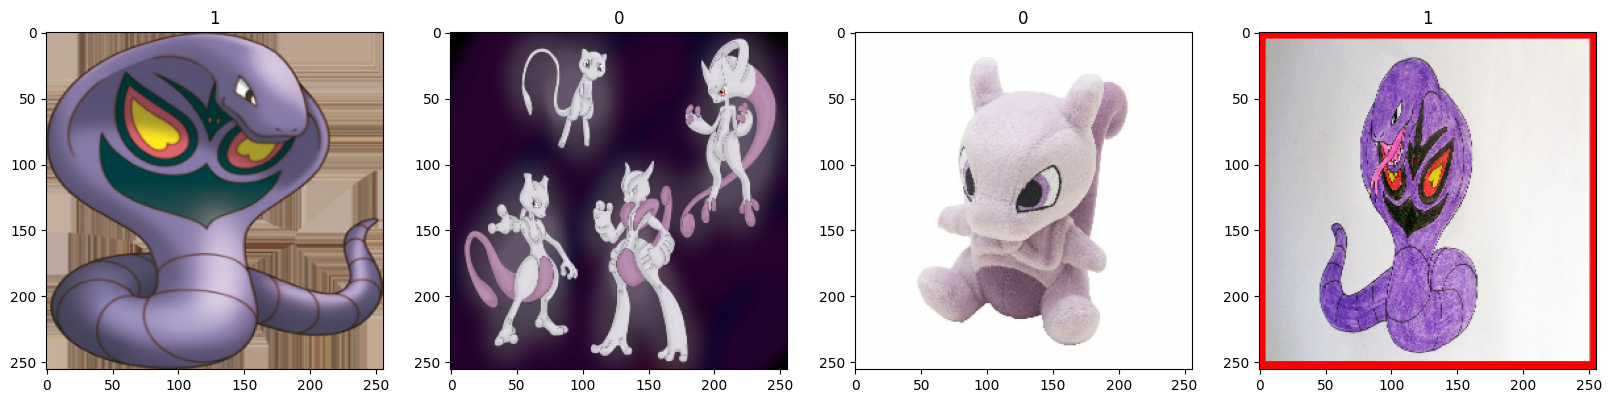

In [16]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

## 2) Baselines

- Random guess accuracy?

- Human-Level Performance accuracy?

- Multilayer Perceptron accuracy?

In [17]:
pip install tf-explain

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 KB 1.2 MB/s eta 0:00:00


In [18]:
import PIL

#load GradCAM
from tf_explain.core.grad_cam import GradCAM

In [19]:
IMAGE_PATH = "/content/drive/My Drive/dataset/mewtwo/11_mewtwo.jpg" 
class_index = 281

In [20]:
img = tf.keras.preprocessing.image.load_img(IMAGE_PATH, target_size=(224, 224))
img = tf.keras.preprocessing.image.img_to_array(img)

In [21]:
model = tf.keras.applications.vgg16.VGG16(weights="imagenet", include_top=True)
#get model summary
model.summary()

553467096/553467096 [==============================] - 20s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                           

In [22]:
#first create the input in a format that the explainer expects (a tuple)
input_img = (np.array([img]), None)

#initialize the explainer as an instance of the GradCAM object
explainer = GradCAM()

# Obtain explanations for your image using VGG 16 and GradCAM
grid = explainer.explain(input_img,
                         model,
                         class_index=class_index
                         )

#save the resulting image
explainer.save(grid, "./outputs/explain/", "grad_cam_mewtwo.png")

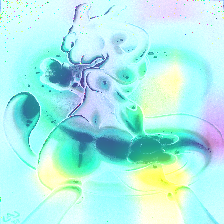

In [23]:
from IPython.display import Image
Image(filename='./outputs/explain/grad_cam_mewtwo.png')

In [24]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [25]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [27]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [28]:
#import tensorflow.compat.v1 as tf

In [29]:
#tf.compat.v1.disable_eager_execution()

In [30]:
#import tensorflow.compat.v1 as tf
#tf.disable_v2_behavior()

In [31]:
print(tf.__version__)

2.12.0


In [32]:
from keras.losses import BinaryCrossentropy

In [33]:
model = Sequential()

model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile('adam', loss=tf.keras.
              losses.BinaryCrossentropy(), metrics=['accuracy'])

tenserboard_callback = tf.keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=1, write_graph=False, write_images=True)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=1, write_graph=False, write_images=True)

hist = model.fit(train, epochs=5, validation_data=val)

Epoch 1/5
14/14 [==============================] - 86s 6s/step - loss: 81.9152 - accuracy: 0.5335 - val_loss: 0.6236 - val_accuracy: 0.6406
Epoch 2/5
14/14 [==============================] - 48s 3s/step - loss: 0.6269 - accuracy: 0.6317 - val_loss: 0.5257 - val_accuracy: 0.6875
Epoch 3/5
14/14 [==============================] - 50s 3s/step - loss: 0.5139 - accuracy: 0.7165 - val_loss: 0.3885 - val_accuracy: 0.8359
Epoch 4/5
14/14 [==============================] - 47s 3s/step - loss: 0.4115 - accuracy: 0.7924 - val_loss: 0.3845 - val_accuracy: 0.8047
Epoch 5/5
14/14 [==============================] - 53s 4s/step - loss: 0.3697 - accuracy: 0.8058 - val_loss: 0.2843 - val_accuracy: 0.8359


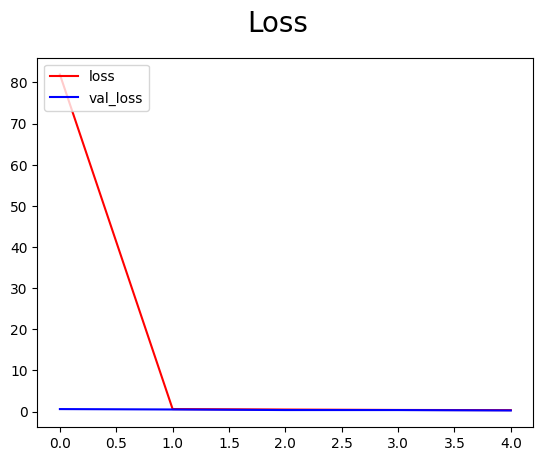

In [34]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='red', label='loss')
plt.plot(hist.history['val_loss'], color='blue', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()


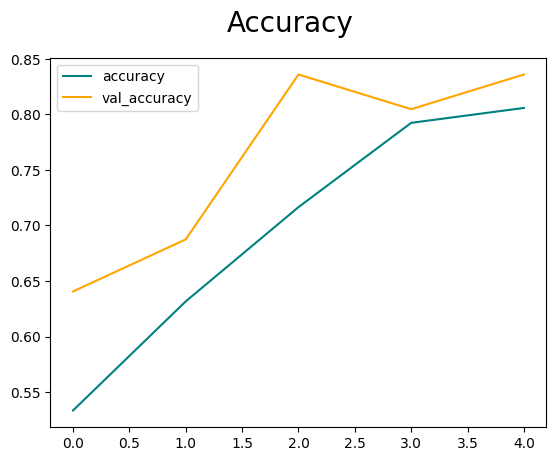

In [35]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [36]:
from sklearn.metrics import confusion_matrix

y_true = [0, 0, 1, 1, 1, 0, 1, 0, 1, 1]
y_pred = [1, 0, 1, 0, 0, 1, 1, 0, 1, 1]

cm = confusion_matrix(y_true, y_pred)

print(cm)

precision_class0 = cm[0, 0] / (cm[0, 0] + cm[1, 0])
precision_class1 = cm[1, 1] / (cm[1, 1] + cm[0, 1])
recall_class0 = cm[0, 0] / (cm[0, 0] + cm[0, 1])
recall_class1 = cm[1, 1] / (cm[1, 1] + cm[1, 0])

f1_class0 = 2 * (precision_class0 * recall_class0) / (precision_class0 + recall_class0)
f1_class1 = 2 * (precision_class1 * recall_class1) / (precision_class1 + recall_class1)
f1_score = (f1_class0 + f1_class1) / 2

print('Precision for Class 0:', precision_class0)
print('Precision for Class 1:', precision_class1)
print('Recall for Class 0:', recall_class0)
print('Recall for Class 1:', recall_class1)
print('F1-score:', f1_score)

[[2 2]
 [2 4]]
Precision for Class 0: 0.5
Precision for Class 1: 0.6666666666666666
Recall for Class 0: 0.5
Recall for Class 1: 0.6666666666666666
F1-score: 0.5833333333333333
